# Tutorial

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

/Users/adamgayoso/.pyenv/versions/3.9.6/bin/python3: Error while finding module specification for 'virtualenvwrapper.hook_loader' (ModuleNotFoundError: No module named 'virtualenvwrapper')
virtualenvwrapper.sh: There was a problem running the initialization hooks.

If Python could not import the module virtualenvwrapper.hook_loader,
check that virtualenvwrapper has been installed for
VIRTUALENVWRAPPER_PYTHON=/Users/adamgayoso/.pyenv/shims/python3 and that PATH is
set properly.


/Users/adamgayoso/.pyenv/versions/3.9.6/envs/velovi/lib/python3.9/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


## Load and preprocess data

In [3]:
adata = scv.datasets.pancreas()

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 21611 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Train and apply model

In [6]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 489/500:  98%|█████████▊| 489/500 [25:50<00:34,  3.17s/it, loss=-2.41e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2337.905. Signaling Trainer to stop.


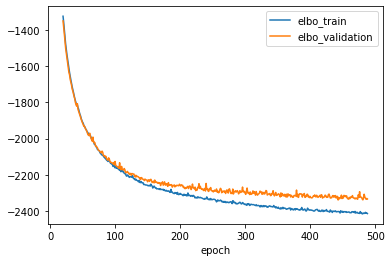

In [7]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

### Get model outputs

In [8]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [9]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/10 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


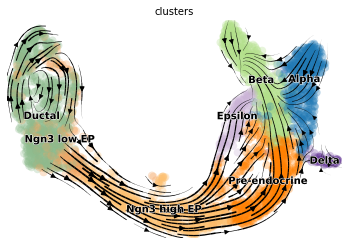

In [10]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Intrinsic uncertainty

In [22]:
uncertainty_df = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     velovi: Sampling from model...                                                      
INFO     velovi: Computing the uncertainties...                                              


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/Users/adamgayoso/.pyenv/versions/3.9.6/envs/velovi/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/adamgayoso/.pyenv/versions/3.9.6/envs/velovi/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/adamgayoso/.pyenv/

,directional_variance,directional_difference,directional_cosine_sim_variance,directional_cosine_sim_difference,directional_cosine_sim_mean
index,,,,,
AAACCTGAGAGGGATA,0.000726,0.077736,0.000406,0.057944,0.665285
AAACCTGAGCCTTGAT,0.001517,0.129804,0.000952,0.102697,0.615747
AAACCTGAGGCAATTA,0.000829,0.095009,0.000485,0.072537,0.643958
AAACCTGCATCATCCC,0.001325,0.123043,0.000751,0.092828,0.653310
AAACCTGGTAAGTGGC,0.000979,0.106826,0.000535,0.078848,0.674464


In [23]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

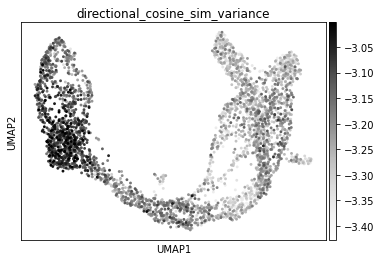

In [24]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99"
)

### Extrinsic uncertainty

In [14]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [15]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:02<00:58,  2.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:04<00:54,  2.38s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:07<00:53,  2.43s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:09<00:49,  2.37s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:12<00:48,  2.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:14<00:46,  2.45s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:16<00:43,  2.43s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:19<00:42,  2.50s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:22<00:41,  2.58s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:25<00:39,  2.61s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:27<00:35,  2.52s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:29<00:32,  2.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [00:32<00:29,  2.48s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [00:34<00:27,  2.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [00:37<00:24,  2.43s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [00:39<00:21,  2.39s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [00:42<00:20,  2.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [00:44<00:17,  2.46s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [00:46<00:14,  2.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [00:49<00:12,  2.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [00:51<00:09,  2.43s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [00:54<00:07,  2.45s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [00:56<00:04,  2.40s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [00:58<00:02,  2.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it]
INFO     velovi: Computing the uncertainties...                                              


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    1.1s finished


In [16]:
for c in ext_uncertainty_df.columns:
    adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[c].values)

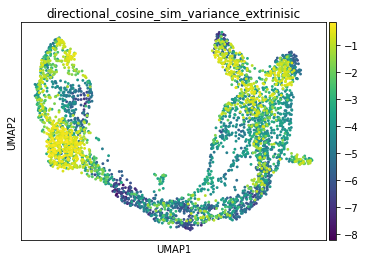

In [17]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinisic",
    # vmin="p1",
    # vmax="p99"
)

### Permutation score

In [18]:
perm_df, _ = vae.get_permutation_scores(labels_key="clusters")
adata.var["permutation_score"] = perm_df.max(1).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


<AxesSubplot:xlabel='permutation_score', ylabel='Density'>

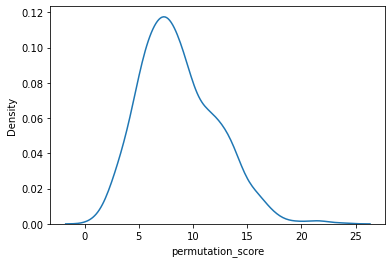

In [19]:
sns.kdeplot(data=adata.var, x="permutation_score")